## Task 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

### Data set

In [2]:
# Load the digits dataset
digits = load_digits()
x_digits, y_digits = digits.data, digits.target

##### Reduce data dimentionaity to for 2-D histogram

In [3]:
# Reduce dimensionality to 2 from 64 for 2-D histogram
pca = PCA(n_components=2)
x_digits_2d = pca.fit_transform(x_digits)


### MMD calculation

### 2-d histogram

In [4]:
# Define histogram bin size as a hyperparameter
def fit_2d_histogram(x, bin_size):
    hist, edges = np.histogramdd(x, bins=[bin_size] * x.shape[1], density=True)
    return hist, edges

def generate_histogram_samples(histogram, edges, n_samples):
    dim = histogram.ndim
    samples = []
    
    # Normalize the histogram to get probabilities
    histogram_probs = histogram / histogram.sum()

    for _ in range(n_samples):
        sample = []
        for d in range(dim):
            # Marginalize histogram along all other dimensions
            marginal_probs = histogram_probs.sum(axis=tuple(i for i in range(dim) if i != d))
            
            # Normalize marginal probabilities to sum to 1
            marginal_probs /= marginal_probs.sum()
            
            # Choose a bin based on the marginal probabilities
            bin_idx = np.random.choice(len(edges[d]) - 1, p=marginal_probs)
            
            # Sample uniformly within the chosen bin
            sample.append(np.random.uniform(edges[d][bin_idx], edges[d][bin_idx + 1]))
        
        samples.append(sample)
    return np.array(samples)


In [5]:
# histogram with bin size
histogram, edges = fit_2d_histogram(x_digits_2d, bin_size=10)

# Evaluate MMD for histogram model
generated_histogram_data_2d = generate_histogram_samples(histogram, edges, n_samples=1000)
# Map 2D samples back to the original 64D space using the inverse PCA transform
generated_histogram_data_64d = pca.inverse_transform(generated_histogram_data_2d)

### Single Gaussian

In [6]:
mean = np.mean(x_digits, axis=0)
covariance = np.cov(x_digits, rowvar=False)

def generate_gaussian_samples(mean, covariance, n_samples):
    return np.random.multivariate_normal(mean, covariance, n_samples)


In [7]:
# data from single Gaussian model
generated_data_gaussian = generate_gaussian_samples(mean, covariance, n_samples=1000)


### GMM

In [8]:
def fit_gmm(X, n_components):
    gmm = GaussianMixture(n_components=n_components, random_state=1)
    gmm.fit(X)
    return gmm

# Generate samples from GMM
def generate_gmm_samples(gmm, n_samples):
    return gmm.sample(n_samples)[0]

In [9]:
# Fit GMM with 10 clusters
gmm = fit_gmm(x_digits, n_components=10)

# data from GMM
generated_data_gmm = generate_gmm_samples(gmm, n_samples=1000)

### KDE

In [10]:
def fit_kde(x, bandwidth):
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
    kde.fit(x)
    return kde

# Generate samples from KDE
def generate_kde_samples(kde, n_samples):
    indices = np.random.choice(len(x_digits), n_samples)
    return x_digits[indices] + kde.sample(n_samples)

In [11]:
# Fit KDE with a specified bandwidth
kde = fit_kde(x_digits, bandwidth=1.0)

generated_data_kde = generate_kde_samples(kde, n_samples=1000)

### MMD

In [12]:
def squared_exponential_kernel(x, y, sigma=1.0):
    return np.exp(-np.linalg.norm(x - y) ** 2 / (2 * sigma ** 2))

def mmd(X, Y, kernel_func, **kwargs):
    m, n = len(X), len(Y)
    XX = np.mean([kernel_func(x, x_prime, **kwargs) for x in X for x_prime in X])
    YY = np.mean([kernel_func(y, y_prime, **kwargs) for y in Y for y_prime in Y])
    XY = np.mean([kernel_func(x, y, **kwargs) for x in X for y in Y])
    return XX + YY - 2 * XY


In [13]:
x_train, x_test, y_train, y_test = train_test_split(x_digits, y_digits, train_size=0.75, random_state=0)

kernel_func=squared_exponential_kernel

# Evaluate MMD for 2-d histogram
mmd_histogram = mmd(x_test, generated_histogram_data_64d, kernel_func)

# Evaluate MMD for single Gaussian model
mmd_gaussian = mmd(x_test, generated_data_gaussian, kernel_func)

# Evaluate MMD for GMM
mmd_gmm = mmd(x_test, generated_data_gmm, kernel_func)

# Evaluate MMD for GMM
mmd_kde = mmd(x_test, generated_data_kde, kernel_func)

print(f"MMD for Histogram model: {mmd_histogram:.4f}")
print(f"MMD for Gaussian model: {mmd_gaussian:.4f}")
print(f"MMD for GMM model: {mmd_gmm:.5f}")
print(f"MMD for KDE model: {mmd_kde:.5f}")

MMD for Histogram model: 0.0057
MMD for Gaussian model: 0.0032
MMD for GMM model: 0.00322
MMD for KDE model: 0.00322


#### Plot

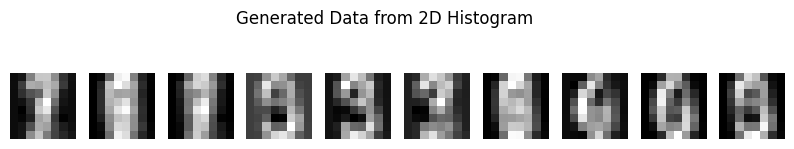

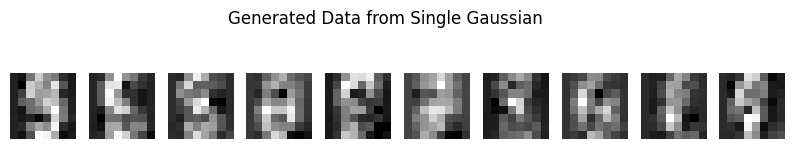

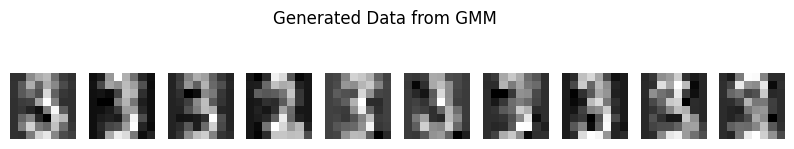

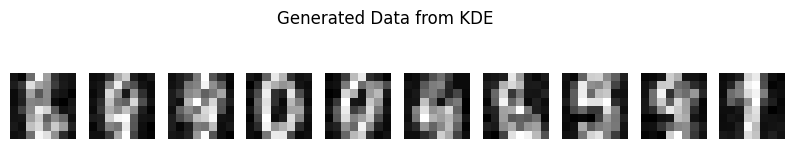

In [14]:
# To plot generated samples
def plot_generated_digits(data, title="Generated Data"):
    n = min(10, data.shape[0])
    plt.figure(figsize=(10, 2))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(data[i].reshape(8, 8), cmap="gray")
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

plot_generated_digits(generated_histogram_data_64d, "Generated Data from 2D Histogram")
plot_generated_digits(generated_data_gaussian, "Generated Data from Single Gaussian")
plot_generated_digits(generated_data_gmm, "Generated Data from GMM")
plot_generated_digits(generated_data_kde, "Generated Data from KDE")

### Random forest classifier

In [15]:
def train_random_forest(X, y):
    clf = RandomForestClassifier(random_state=0)
    clf.fit(X, y)
    return clf

# Train classifier on original dataset
clf = train_random_forest(x_train, y_train)


In [16]:
# train a RandomForestClassifier on the original dataset
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=0)
rf_classifier.fit(x_digits, y_digits)

# Step 4: Classify generated samples to check recognizability
def evaluate(model_name, generated_data):
    labels_pred = rf_classifier.predict(generated_data)
    accuracy = accuracy_score(y_digits[:len(labels_pred)], labels_pred)
    print(f"Approximate recognizability accuracy for {model_name}: {accuracy:.4f}")

# Evaluate accuracy of generated samples
evaluate("2D Histogram", generated_histogram_data_64d)
evaluate("Single Gaussian", generated_data_gaussian)
evaluate("GMM", generated_data_gmm)
evaluate("KDE", generated_data_kde)



Approximate recognizability accuracy for 2D Histogram: 0.1040
Approximate recognizability accuracy for Single Gaussian: 0.1000
Approximate recognizability accuracy for GMM: 0.1020
Approximate recognizability accuracy for KDE: 0.1000
